### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 29th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.


4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

# <font color='green'>**PART ONE!**</font>

<font color='orange'>Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature. </font>

Ok! Let's start!

The initial code in this notebook talked a lot about setting up the interactive widgets, so I will demonstrate it along with importing the data to show how it works (mostly for myself).

In [1]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

Here's what to do with a static plotting cell:

In [ ]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

Import statements!!! Very useful for the rest of the notebook:

In [2]:
# Import statements 
# As many little things as I can catch now!!
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform

Now, downloading and organizing the data:

In [3]:
# Organizing the data
data = np.load("hw7_data_1.npy") # Loading the dataset
feature1 = data[:, 0]
feature2 = data[:, 1] 
labels = data[:, 2].astype(int) # Was having trouble bc these were casting as floats. No longer!
het_errors = data[:, 3]

Ok! Here's my test with the widget feature. Actually really cool! I don't think I can go back to the other way (lol):

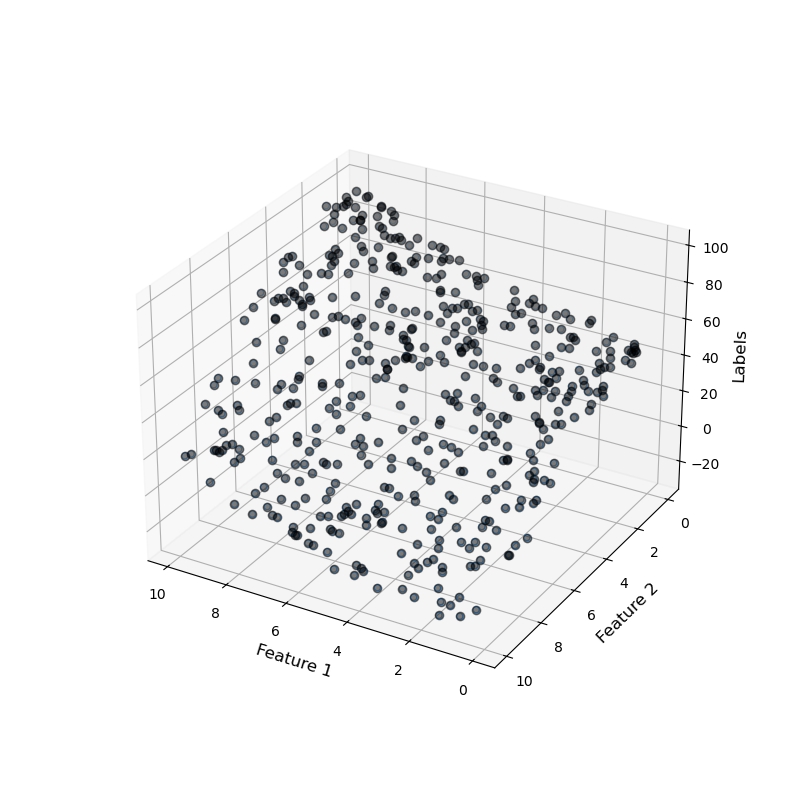

In [6]:
# Makes the plot interactive. 
# You can pan the image.

# NOTE THIS IS ME TESTING OUT THE WIDGETS!!

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(feature1, feature2, labels, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(feature1.flatten(), feature2.flatten(), labels, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_zlabel('Labels', fontsize=12)

ax.view_init(elev=28, azim=120)

Now, I will do what the question asks: two panels, one of each feature vs the labels:

/var/folders/8_/vd_n6g9d37gbs_dfstk2qklw0000gr/T/ipykernel_66109/3573817011.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


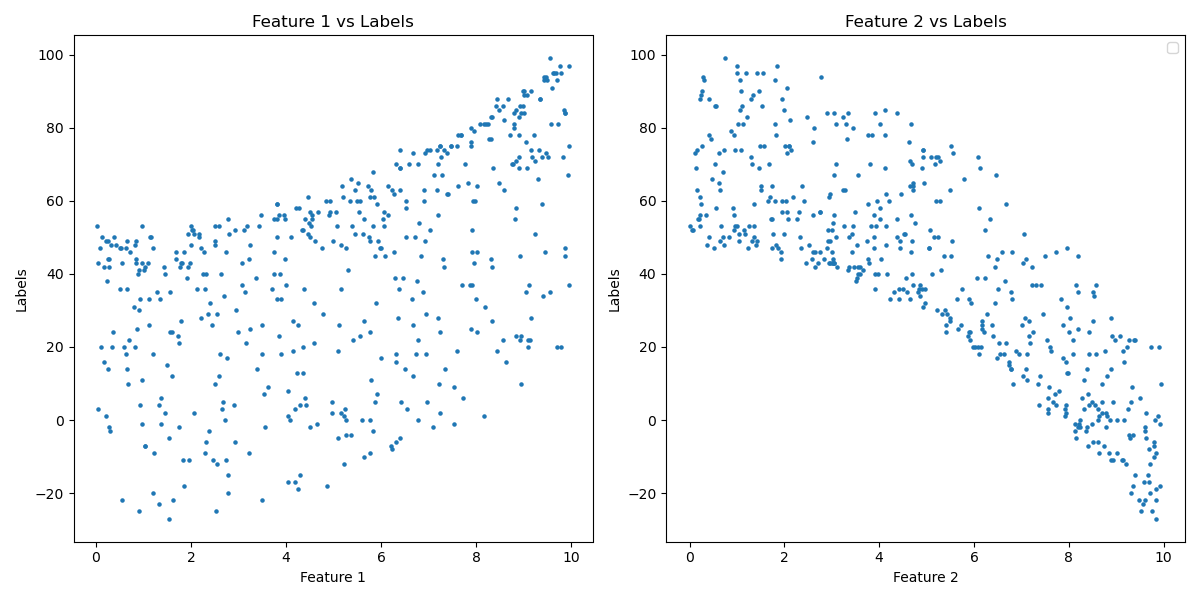

In [5]:
# Creating the subolots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Panel A: Feature 1 vs Labels
scatter1 = axes[0].scatter(feature1, labels, s=5)
axes[0].set_title("Feature 1 vs Labels")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Labels")

# Panel B: KMeans clusters
scatter2 = axes[1].scatter(feature2, labels, s=5)
axes[1].set_title("Feature 2 vs Labels")
axes[1].set_xlabel("Feature 2")
axes[1].set_ylabel("Labels")
axes[1].legend()

# Making the plots look cool B)
plt.tight_layout()
plt.show()

# <font color='green'>**PART TWO!**</font>

<font color='orange'>Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?</font>

Alright! The first thing I'm going to do is import the linear regression tool from astroML:

In [ ]:
from astroML.linear_model import LinearRegression

Here's my organization of the data:

In [ ]:
X = np.vstack([feature1, feature2]).T   # shape (500, 2)
y = labels
dy = het_errors

NOW, I will actually do the thing I was asked to do, and give you the best-fit intercept and slopes in return:

In [ ]:
# Actually doing the multivariate linear regression
model = LinearRegression()
model.fit(X, y, dy)

# Printouts!!
print("Intercept:", model.coef_[0])
print("Slopes:", model.coef_[1:])

Intercept: 56.48245078374233
Slopes: [ 4.93878589 -8.23758388]


/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


Now, let's cover the back half of this question. We are asked to make a prediction Xgrid of 50 values on each axis, spanning from the minimum to maximum vlaues of each feature. First, let's make the axes!

In [ ]:
f1_vals = np.linspace(feature1.min(), feature1.max(), 50)
f2_vals = np.linspace(feature2.min(), feature2.max(), 50)

Now, le'ts make the grids!! Again, using np.ravel, because it is an awesome function:

In [ ]:
F1, F2 = np.meshgrid(f1_vals, f2_vals)
Xgrid = np.vstack([F1.ravel(), F2.ravel()]).T  # shape (2500, 2)

Now, we do the predictions, and also reshape it so that it matches the original grid's shape

In [ ]:
y_pred_grid = model.predict(Xgrid)
Y_pred = y_pred_grid.reshape(F1.shape)

Nice!! Now, we must graph this thing! First thing's first, I want to figure out how to make the fits work in each panel of the plot. The way to do this, I believe, is to fix the feature that is not varying in each graph at its mean. This means (haha) the varying feature will create the best fit line along the best possible location for a best fit line. I make these lines here:

In [ ]:
# Panel A: Feature 1 vs Labels
f2_mean = np.mean(feature2) # Fixing feature 2 by setting it equal to its mean
X_line1 = np.column_stack([f1_vals, np.full_like(f1_vals, f2_mean)]) # Creating the line
y_fit1 = model.predict(X_line1) # Predicting the labels

# Panel B: Feature 2 vs Labels
f1_mean = np.mean(feature1) # Fixing feature 1 by setting it equal to its mean
X_line2 = np.column_stack([np.full_like(f2_vals, f1_mean), f2_vals]) # Creating the line
y_fit2 = model.predict(X_line2) # Predicting the labels

Now, we make the graphs!

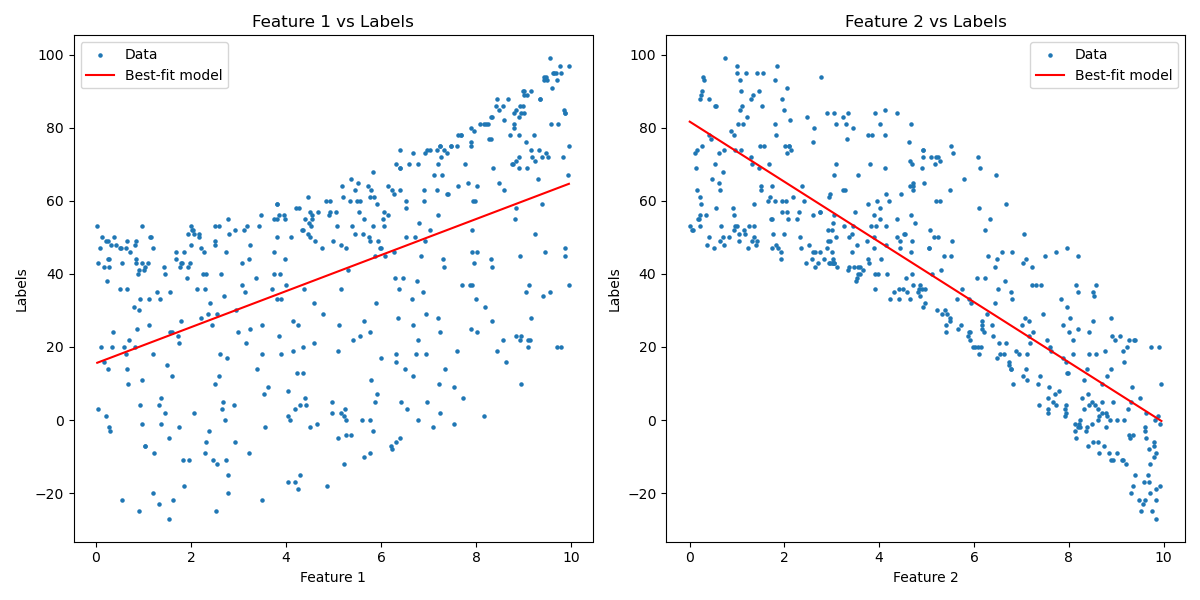

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Creation of Panel A
axes[0].scatter(feature1, labels, s=5, label='Data')
axes[0].plot(f1_vals, y_fit1, color='red', label='Best-fit model')
axes[0].set_title("Feature 1 vs Labels")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Labels")
axes[0].legend()

# Creation of Panel B
axes[1].scatter(feature2, labels, s=5, label='Data')
axes[1].plot(f2_vals, y_fit2, color='red', label='Best-fit model')
axes[1].set_title("Feature 2 vs Labels")
axes[1].set_xlabel("Feature 2")
axes[1].set_ylabel("Labels")
axes[1].legend()

plt.tight_layout()
plt.show()


To be honest,t he fits going on here aren't bad at all!!! I like it a lot!!

# <font color='green'>**PART THREE!**</font>

<font color='orange'>Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space.</font>

First, we make a NEW meshgrid over the while 2D feature space. I'm using the same strategy of min/maxes to get a uniform parameter space:

In [37]:
f1_vals = np.linspace(feature1.min(), feature1.max(), 50)
f2_vals = np.linspace(feature2.min(), feature2.max(), 50)
F1new, F2new = np.meshgrid(f1_vals, f2_vals)

Here, we do another prediction just like the one before it, but now going into three dimensions!!

In [38]:
Xgridnew = np.vstack([F1new.ravel(), F2new.ravel()]).T
Z_pred = model.predict(Xgridnew).reshape(F1new.shape)

Alright! Let's plot this thing!

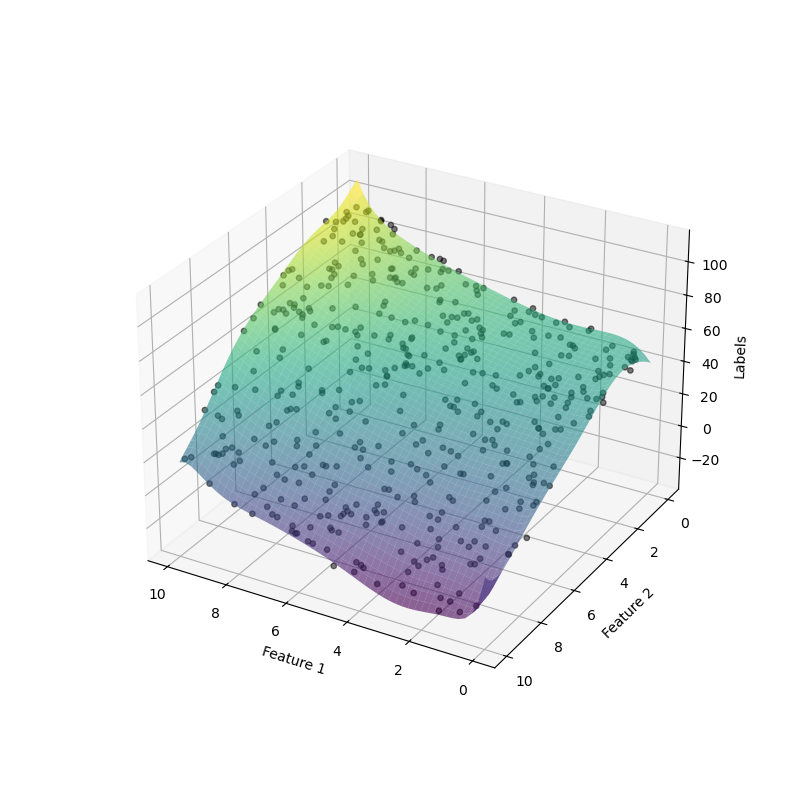

In [ ]:
# Plotting
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, labels, color='k', alpha=0.5, s=15)
ax.plot_surface(F1new, F2new, Z_pred, cmap='viridis', alpha=0.6)

# Labels and view
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Labels')
ax.view_init(elev=28, azim=120)

plt.show()


Not bad!!! Not bad at all!

# <font color='green'>**PART FOUR!**</font>

<font color='orange'>Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*</font>

Here are a few useful imports for this section!!

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

For this part of the project, I organize the data as so (pulling from the features themselves, NOT my meshgrid)

In [ ]:
X = np.vstack([feature1, feature2]).T
y = labels

Here is my ridge_params definition:

In [ ]:
ridge_params = {'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}

And here we do the ridge regression! Printed out the parameters and CV score, too!

In [ ]:
# Doing the ridge regression
ridge = Ridge()
grid = GridSearchCV(ridge, ridge_params, cv=5)
grid.fit(X, y)

# Results
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best params: {'alpha': 1.0, 'solver': 'svd'}
Best CV score: 0.9301328145633814


From this, I collect the best parameters and then construct my Z-axis prediction:

In [ ]:
best_ridge = grid.best_estimator_
Z_ridge = best_ridge.predict(Xgrid).reshape(F1.shape)

Here is my plot!

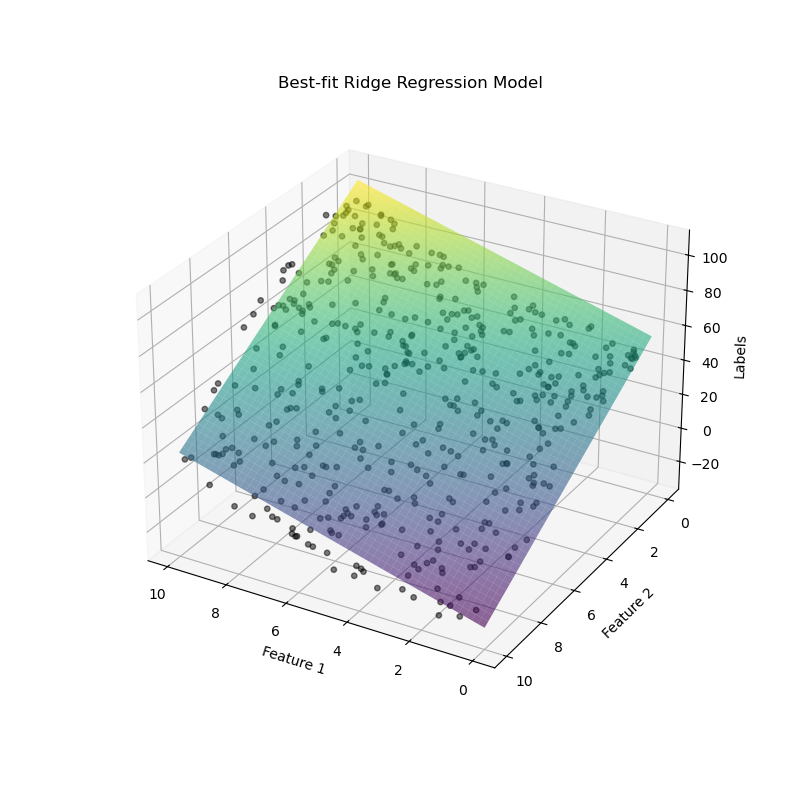

In [ ]:
# Plotting
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, labels, color='k', alpha=0.5, s=15, label='Data')
ax.plot_surface(F1, F2, Z_ridge, cmap='viridis', alpha=0.6)

# Labels and view
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Labels")
ax.set_title("Best-fit Ridge Regression Model")
ax.view_init(elev=28, azim=120)

plt.show()


Perfect! Now, let's check if RidgeCV spits out the same thing:

In [ ]:
# Extra import!
from sklearn.linear_model import RidgeCV

#Doing RidgeCV
ridge_cv = RidgeCV(alphas=[0.05, 0.1, 0.2, 0.5, 1.0], store_cv_values=True)
ridge_cv.fit(X, y)

#Printing the result
print("RidgeCV best alpha:", ridge_cv.alpha_)


RidgeCV best alpha: 1.0


/Users/blakeghg/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Nice!! They line up!

# <font color='green'>**PART FIVE!**</font>

<font color='orange'>Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*</font>

Here are my import statements:

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor


Here is my data organization:

In [41]:
X = np.vstack([feature1, feature2]).T
y = labels
dy = het_errors

Here's how I'm doing the gpr with the alpha errors:

In [ ]:
alpha_with_err = (dy / y) ** 2
gpr_with_err = GaussianProcessRegressor(alpha=alpha_with_err, normalize_y=True)
gpr_with_err.fit(X, y)

/var/folders/8_/vd_n6g9d37gbs_dfstk2qklw0000gr/T/ipykernel_66109/1769163570.py:1: RuntimeWarning: divide by zero encountered in divide
  alpha_with_err = (dy / y) ** 2


GaussianProcessRegressor(alpha=array([5.49758487e-04, 3.84457109e-03, 2.65933001e-03, 2.49322216e-03,
       2.65218702e-03, 7.81793273e-04, 1.98118434e-04, 1.69625265e-03,
       6.46663480e-04, 1.63429391e-01, 1.32618212e-03, 4.26285937e-04,
       9.12695679e-04, 1.21325725e-03, 8.57452814e-04, 3.89720854e-04,
       1.53941588e-02, 3.29618656e-04, 4.30117416e+00, 3.09775633e-04,
       4.27049377e-...
       5.53421016e-03, 3.15051435e-03, 7.33591243e-04, 7.10699980e-04,
       5.73006913e-04, 1.11961281e-03, 2.00187898e-03, 5.69565606e-04,
       4.87722753e-04, 3.54277909e-03, 1.00443294e-03, 2.25719913e-03,
       2.75011502e-02, 1.41033166e-03, 2.04718145e-04, 4.09124203e-01,
       1.07649578e-01, 9.10562198e-01, 3.90859904e-03, 1.61896498e-04,
       2.64653313e-03, 3.43122343e-01, 1.20763465e-03, 1.07356944e-02]),
                         normalize_y=True)

And here it is without! (I put alpha=10^-10 bc it seems to line up well with the array from above):

In [43]:
gpr_no_err = GaussianProcessRegressor(alpha=1e-3, normalize_y=True)
gpr_no_err.fit(X, y)


GaussianProcessRegressor(alpha=0.001, normalize_y=True)

Here are my predictions for the Z values:

In [44]:
Z_gpr_with_err = gpr_with_err.predict(Xgrid).reshape(F1.shape)
Z_gpr_no_err = gpr_no_err.predict(Xgrid).reshape(F1.shape)


Now let's plot these sons of bitches!

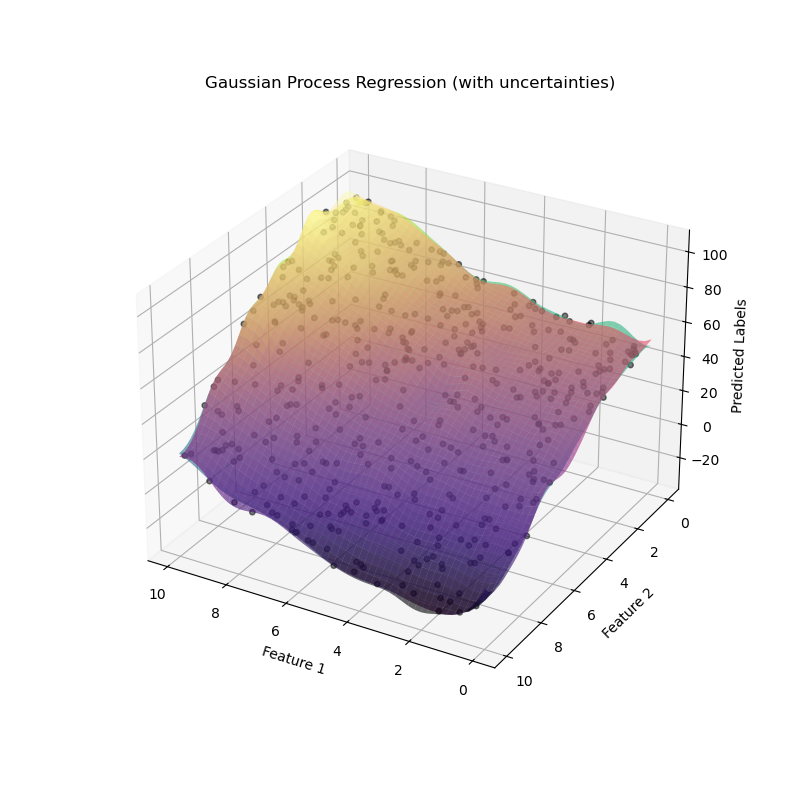

In [45]:
# Plotting
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, labels, color='k', alpha=0.5, s=15, label='Data')
ax.plot_surface(F1, F2, Z_gpr_with_err, cmap='viridis', alpha=0.6)
ax.plot_surface(F1, F2, Z_gpr_no_err, cmap='magma', alpha=0.6)

# Labels and view
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Predicted Labels")
ax.set_title("Gaussian Process Regression (with uncertainties)")
ax.view_init(elev=28, azim=120)

plt.show()


Looking really good!

# <font color='green'>**PART SIX!**</font>

<font color='orange'>Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?</font>

Imports for this section:

In [46]:
from astroML.linear_model import PolynomialRegression
from sklearn.linear_model import LinearRegression


And now the data organization:

In [47]:
X = np.vstack([feature1, feature2]).T
y = labels

Now, since we are constructing a polynomial fit, we use PolynomialRegression from the model, constructing a polynomial fit of degree 4 and fitting it:

In [51]:
degree = 4
model_poly = PolynomialRegression(degree)
model_poly.fit(X, y)


PolynomialRegression(degree=4)

Here's our predictions (and the coefficients):

In [55]:
Z_poly = model_poly.predict(Xgrid).reshape(F1.shape)

print(model_poly.coef_)

[ 4.98746659e+01  1.53819013e-01 -2.45316267e-01  4.24134879e-01
  2.50543770e-02 -7.68952455e-01  5.81501013e-03  2.06946459e-02
 -1.85902607e-02  5.63798819e-03 -1.78074072e-04 -1.32053252e-04
 -2.29682513e-03  2.00532748e-03 -6.63883479e-04]


And now for the plotting!

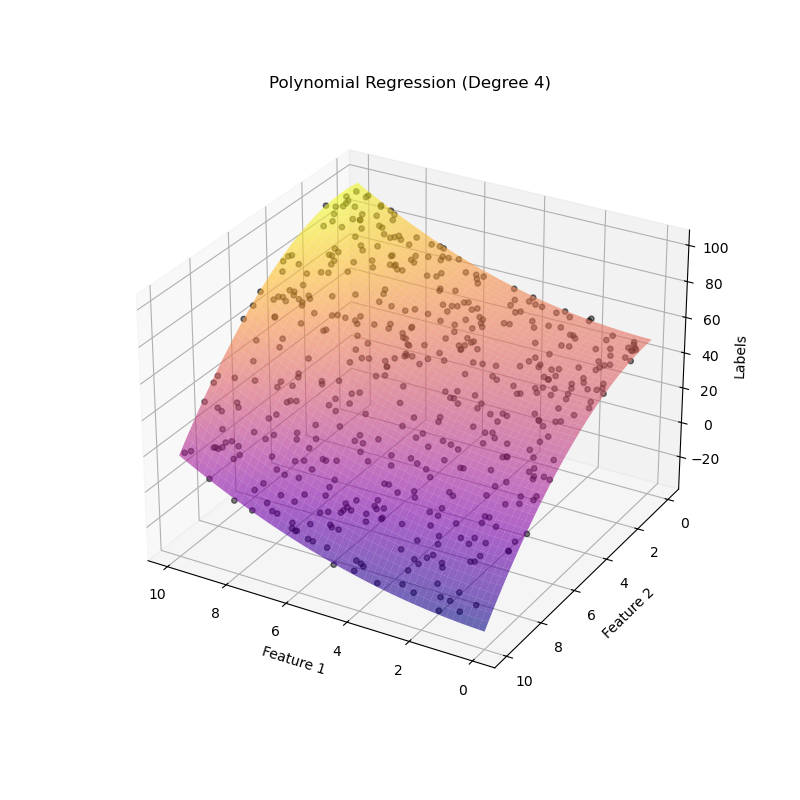

In [56]:
# Plotting
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, labels, color='k', alpha=0.5, s=15, label='Data')
ax.plot_surface(F1, F2, Z_poly, cmap='plasma', alpha=0.6)

# Labels and view
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Labels")
ax.set_title(f"Polynomial Regression (Degree {degree})")
ax.view_init(elev=28, azim=120)

plt.show()


# <font color='green'>**PART SEVEN!**</font>

<font color='orange'>Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.</font>

Now, for the endgame!

In [57]:
from sklearn.model_selection import train_test_split

Using the same X/y/dy data organization as before, we create this set of train/test splits (20%)

In [ ]:
# Splitting into train and test (80/20)
X_train, X_test, y_train, y_test, dy_train, dy_test = train_test_split(
    X, y, dy, test_size=0.2, random_state=42)

# Further splitting train into subtrain and cross-validation (80/20 of training set)
X_subtrain, X_cv, y_subtrain, y_cv = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

This chunk of cide is a bit complicated,a s I had to use the for loop depicted below. For each of the degrees, I create a polynomial regression model, made predictions with the subtrain/cross-validation sets, and then calcualted the RMS errors as well as the BIC criterion. 

In [ ]:
# Setting up everything
degrees = np.arange(1, 11)
train_rms = []
cv_rms = []
bic_vals = []

# The loop for each degree!
for deg in degrees:
    # Polynomial regression model
    model = PolynomialRegression(degree=deg)
    model.fit(X_subtrain, y_subtrain)
    
    # Predictions for subtrain/cross-validation
    y_sub_pred = model.predict(X_subtrain)
    y_cv_pred = model.predict(X_cv)
    
    # RMS errors
    rms_train = np.sqrt(np.mean((y_subtrain - y_sub_pred) ** 2))
    rms_cv = np.sqrt(np.mean((y_cv - y_cv_pred) ** 2))
    
    # BIC criterion (n * log(RSS/n) + k * log(n))
    n = len(y_cv)
    k = model.coef_.shape[0]
    rss = np.sum((y_cv - y_cv_pred) ** 2)
    bic = n * np.log(rss / n) + k * np.log(n)
    
    # Finishing out the loop
    train_rms.append(rms_train)
    cv_rms.append(rms_cv)
    bic_vals.append(bic)


Once all of that is done, we plot! (Interactive bc I like it :)

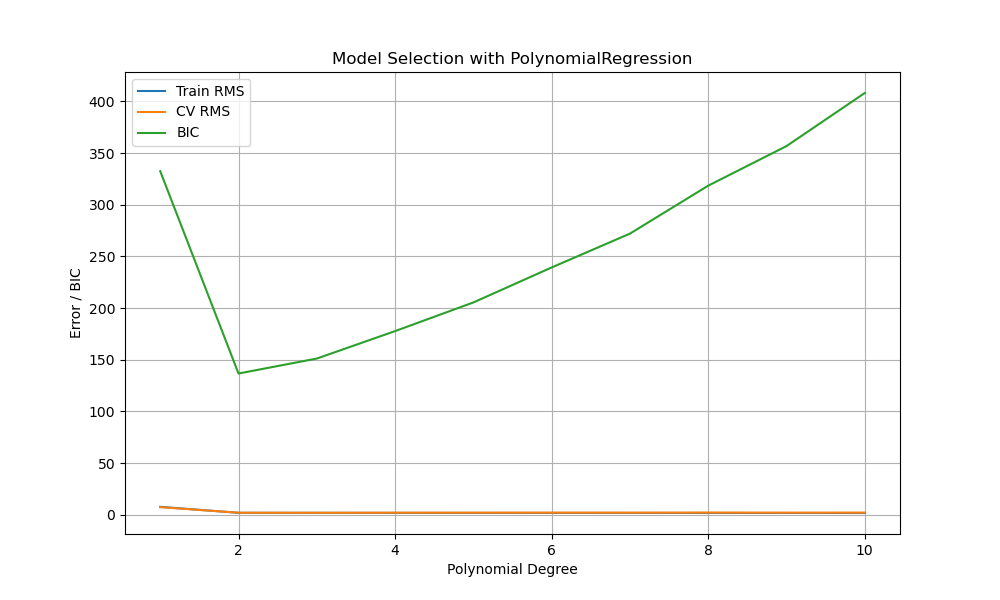

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_rms, label="Train RMS")
plt.plot(degrees, cv_rms, label="CV RMS")
plt.plot(degrees, bic_vals, label="BIC")
plt.xlabel("Polynomial Degree")
plt.ylabel("Error / BIC")
plt.title("Model Selection with PolynomialRegression")
plt.legend()
plt.grid(True)
plt.show()


Finally, I give you the best degree!

In [59]:
best_degree = degrees[np.argmin(cv_rms)]
print("Best degree:", best_degree)

Best degree: 3


Nice!!! With this, we retrain the data and give out the final test RMS, finishing the notebook!

In [60]:
# Retraining on full training set
final_model = PolynomialRegression(degree=best_degree)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# Calculating the final test RMS
test_rms = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print("Final test RMS:", test_rms)


Final test RMS: 1.994899492635569
